# Potato Disease Classification
Dataset credit: https://www.kaggle.com/arjuntejaswi/plant-village

##  Import all dependencies

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

## Set all the constant

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

## Import data to tensorflow object
- We will use standard tensorflow api (image_dataset_from_directory) to load all image from given directory to variable
- class_name - get from folder name

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 1 1 1 0 0 1 1 1 1 0 0 2 1 0 1 1 0 0 1 0 2 0 1 0 0 0 0 0 1 1]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy().shape)

(256, 256, 3)


## Visualize image from dataset

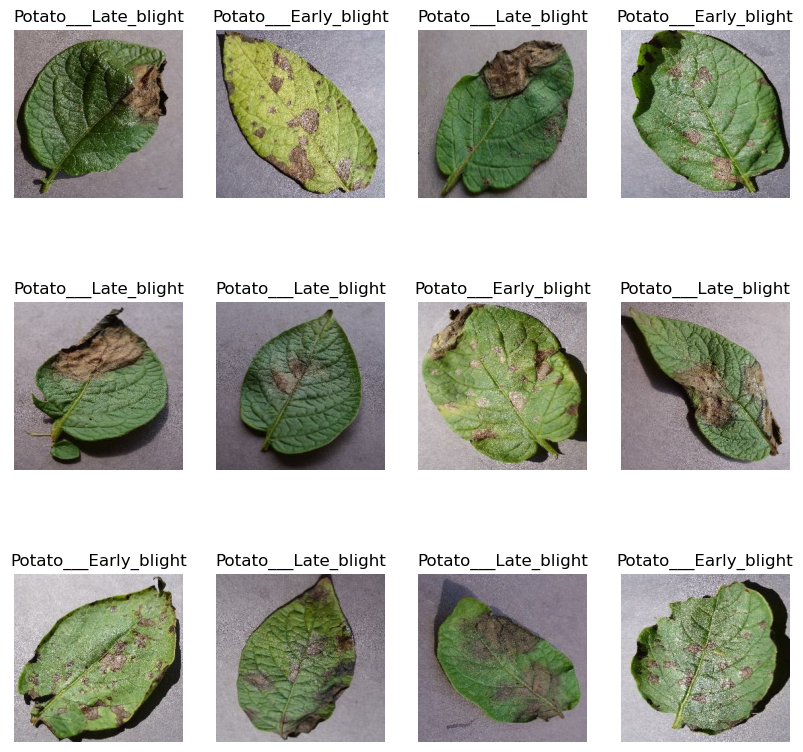

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

## Split data to
- train dataset --> 80% of dataset
- validation dataset --> 10% of dataset
- test dataset --> remaining dataset

In [9]:
train_ds = dataset.take(54) # 80% of dataset
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*0.1

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

## Cache, shuffle, prefetch
- to make the training process more efficiency due to not load data again when starting new epochs

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Build the model

### Create resize and rescale layer
- resize to 256*256 pixel for each image
- rescale - each pixel divided by 255 to keep data vary from 0 to 1

In [20]:
resize_and_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

### Create data augmentation layer to make model more robust
- random flip
- random rotation

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescaling,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 50s 866ms/step - loss: 0.8943 - accuracy: 0.4890 - val_loss: 0.8028 - val_accuracy: 0.6510
Epoch 2/50
54/54 [==============================] - 46s 853ms/step - loss: 0.6045 - accuracy: 0.7106 - val_loss: 0.4945 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 46s 859ms/step - loss: 0.4439 - accuracy: 0.8079 - val_loss: 0.4342 - val_accuracy: 0.8021
Epoch 4/50
54/54 [==============================] - 45s 830ms/step - loss: 0.3476 - accuracy: 0.8513 - val_loss: 0.3194 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 42s 775ms/step - loss: 0.3107 - accuracy: 0.8709 - val_loss: 0.3638 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 42s 772ms/step - loss: 0.2430 - accuracy: 0.9039 - val_loss: 0.2104 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 42s 778ms/step - loss: 0.1738 - accuracy: 0.9329 - val_loss: 0.1512 - val_accuracy: 0.9583

54/54 [==============================] - 45s 832ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.0797 - val_accuracy: 0.9844
Epoch 42/50
54/54 [==============================] - 45s 831ms/step - loss: 0.0181 - accuracy: 0.9925 - val_loss: 0.0188 - val_accuracy: 0.9896
Epoch 43/50
54/54 [==============================] - 45s 831ms/step - loss: 0.0266 - accuracy: 0.9884 - val_loss: 0.1652 - val_accuracy: 0.9531
Epoch 44/50
54/54 [==============================] - 45s 836ms/step - loss: 0.0647 - accuracy: 0.9763 - val_loss: 0.0503 - val_accuracy: 0.9844
Epoch 45/50
54/54 [==============================] - 45s 827ms/step - loss: 0.0544 - accuracy: 0.9826 - val_loss: 0.0756 - val_accuracy: 0.9792
Epoch 46/50
54/54 [==============================] - 45s 829ms/step - loss: 0.0199 - accuracy: 0.9942 - val_loss: 0.0378 - val_accuracy: 0.9896
Epoch 47/50
54/54 [==============================] - 45s 825ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.0684 - val_accuracy: 0.9896
Epoc

In [30]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 160ms/step - loss: 0.0778 - accuracy: 0.9766


In [29]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.48900464177131653,
 0.7106481194496155,
 0.8078703880310059,
 0.8512731194496155,
 0.8709490895271301,
 0.9039351940155029,
 0.9328703880310059,
 0.9473379850387573,
 0.9502314925193787,
 0.9496527910232544,
 0.9618055820465088,
 0.9756944179534912,
 0.9803240895271301,
 0.9855324029922485,
 0.9560185074806213,
 0.9762731194496155,
 0.9768518805503845,
 0.9855324029922485,
 0.9797453880310059,
 0.9646990895271301,
 0.9762731194496155,
 0.9861111044883728,
 0.9907407164573669,
 0.9947916865348816,
 0.9809027910232544,
 0.9716435074806213,
 0.9947916865348816,
 0.9913194179534912,
 0.9942129850387573,
 0.9971064925193787,
 0.9976851940155029,
 0.9971064925193787,
 0.9936342835426331,
 0.9930555820465088,
 0.9942129850387573,
 0.9664351940155029,
 0.984375,
 0.9907407164573669,
 0.9728009104728699,
 0.9971064925193787,
 0.9982638955116272,
 0.9924768805503845,
 0.9884259104728699,
 0.9762731194496155,
 0.9826388955116272,
 0.9942129850387573,
 0.9988425970077515,
 0.9884259104728699,
 

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

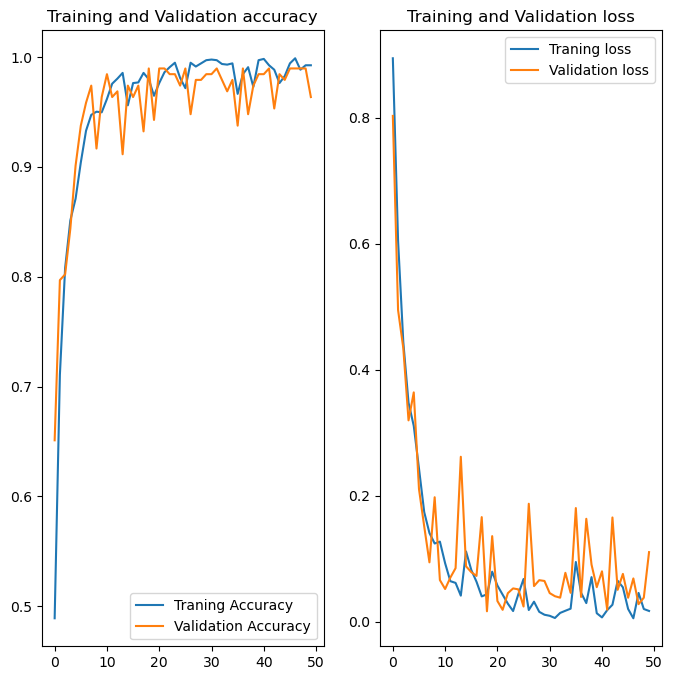

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Traning Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Traning loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.show()

In [3]:
import numpy as np

first image to predict
first image actual label: Potato___Early_blight
1/1 [==============================] - 0s 227ms/step
first image predict label: Potato___Early_blight


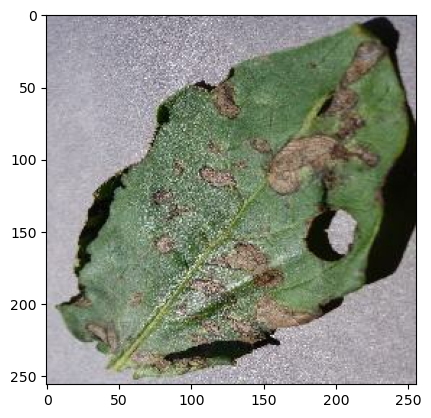

In [48]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image actual label:",class_name[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("first image predict label:", class_name[np.argmax(batch_prediction[0])])

In [49]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 84ms/step


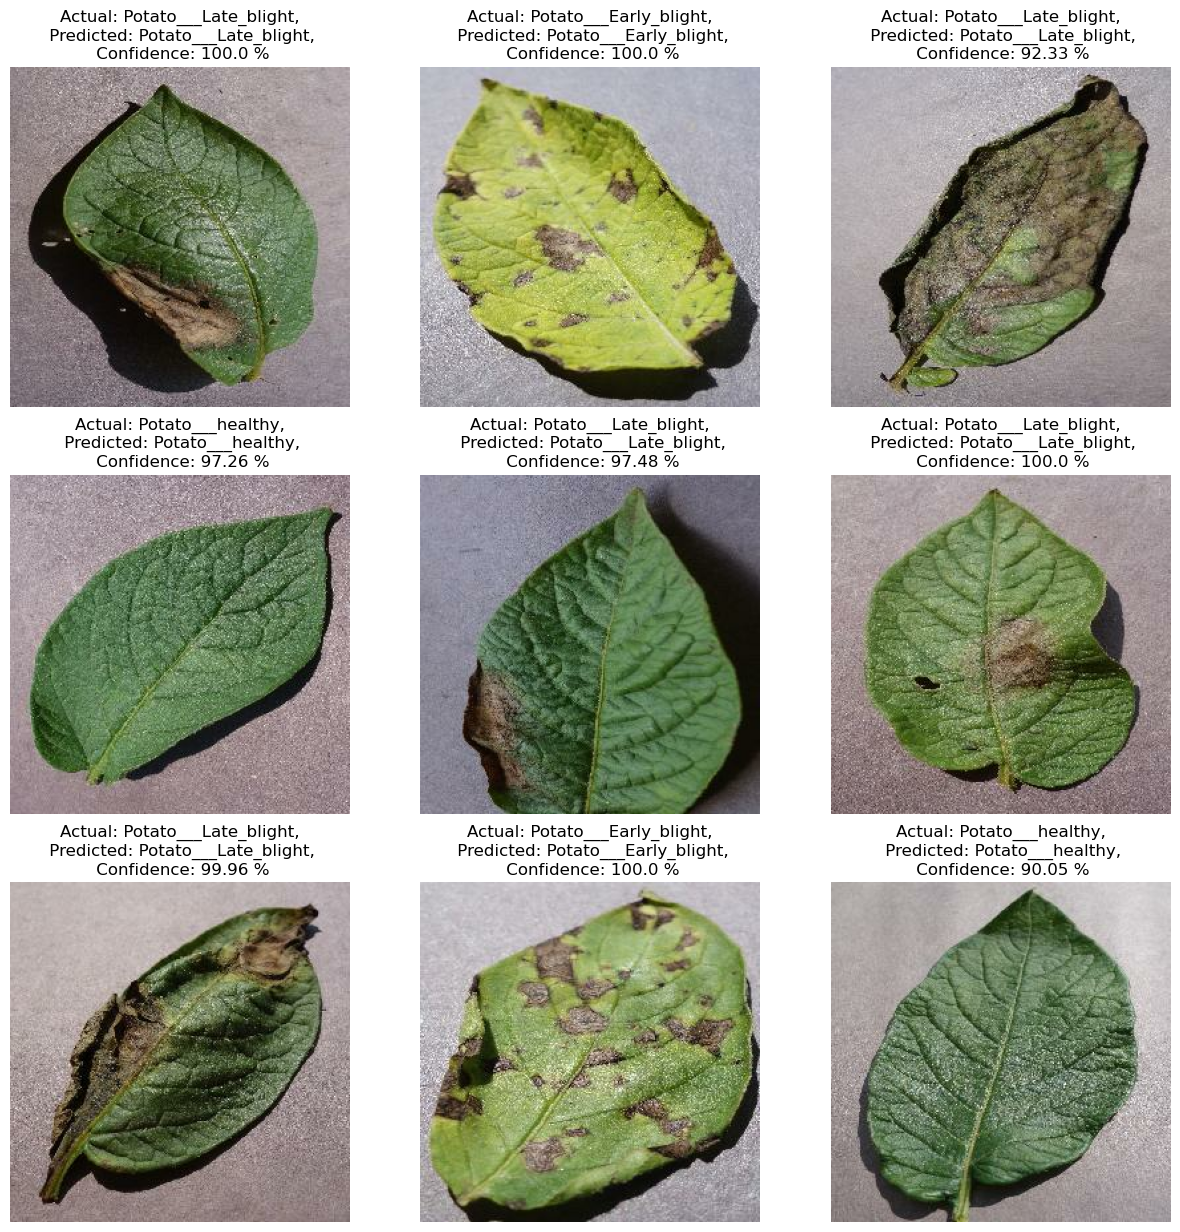

In [52]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1): # take 1 batch or 32 images
    for i in range(9): # take 9 image
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence} %")
        
        plt.axis('off')

In [53]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [57]:
import os

model_version = max([int(i) for i in os.listdir("../models/")]) + 1
model.save(f"../models/{model_version}")


INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
